In [1]:
import collections
import gzip
import json
import os
import re
import string
import subprocess
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20230831_scBarcode')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20230831_scBarcode')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20230831_scBarcode')
DIR_REF = os.path.join(DIR_PROJECT, 'data_ref')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)

In [3]:
n_threads = 10

# Code Setup

In [4]:
from contextlib import AbstractContextManager

class BashRunnerWithSharedEnvironment(AbstractContextManager):
    """
    Run multiple bash scripts with persisent environment.
    Environment is stored to "env" member between runs. This can be updated
    directly to adjust the environment, or read to get variables.
    """

    def __init__(self, env=None):
        if env is None:
            env = dict(os.environ)
        self.env: Dict[str, str] = env
        self._fd_read, self._fd_write = os.pipe()

    def run(self, cmd, **opts):
        if self._fd_read is None:
            raise RuntimeError("BashRunner is already closed")
        write_env_pycode = ";".join(
            [
                "import os",
                "import json",
                f"os.write({self._fd_write}, json.dumps(dict(os.environ)).encode())",
            ]
        )
        write_env_shell_cmd = f"{sys.executable} -c '{write_env_pycode}'"
        cmd += "\n" + write_env_shell_cmd
        result = subprocess.run(
            ["bash", "-ce", cmd], pass_fds=[self._fd_write], env=self.env, **opts
        )
        self.env = json.loads(os.read(self._fd_read, 50000).decode())
        return result

    def __exit__(self, exc_type, exc_value, traceback):
        if self._fd_read:
            os.close(self._fd_read)
            os.close(self._fd_write)
            self._fd_read = None
            self._fd_write = None

    def __del__(self):
        self.__exit__(None, None, None)

In [5]:
def fastq_parse(fp):
    """
    Parse fastq file.
    """
    linecount = 0
    name, seq, thrd, qual = [None] * 4
    for line in fp:
        linecount += 1
        try:
            line_stripped = line.decode("UTF-8").rstrip()
        except AttributeError:
            line_stripped = line.rstrip()
        if linecount % 4 == 1:
            name = line_stripped
            assert name.startswith("@")
        elif linecount % 4 == 2:
            seq = line_stripped
        elif linecount % 4 == 3:
            thrd = line_stripped
            assert thrd.startswith("+")
        elif linecount % 4 == 0:
            qual = line_stripped
            assert len(seq) == len(qual)
            yield name, seq, thrd, qual
            name, seq, thrd, qual = [None] * 4

In [6]:
dict_complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
def reverse_complement(s, allow_noncanonical=False):
    if allow_noncanonical is False:
        return ''.join(dict_complement[base] for base in reversed(s))
    else:
        return ''.join(dict_complement.get(base, base) for base in reversed(s))

In [7]:
sprite_env = BashRunnerWithSharedEnvironment()
sprite_env.run('source ~/.bashrc; conda activate chipdip')

CompletedProcess(args=['bash', '-ce', "source ~/.bashrc; conda activate chipdip\n/home/btyeh/miniconda3/envs/py3/bin/python -c 'import os;import json;os.write(59, json.dumps(dict(os.environ)).encode())'"], returncode=0)

# Data

In [140]:
regex_fastq_files = re.compile((
    r'(?P<filename>\S+_(?P<sample>(?P<cell_count>\d+)_(?P<FACS>Singlet|Doublet_plus)_cells_'
    r'aliquot_(?P<aliquot>\d+))_.*R(?P<read>1|2)_001.fastq.gz)'))

In [141]:
df_data = pd.DataFrame([regex_fastq_files.match(file).groupdict() for file in os.listdir(DIR_DATA)]) \
    .astype(dict(cell_count=int, aliquot=int, read=int, FACS='category', sample='category'))

In [142]:
popen_counts = dict()
for sample, group in df_data.groupby('sample'):
    filename = group.loc[group['read'] == 1, 'filename'].item()
    cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
    popen_counts[sample] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)

In [143]:
df_data['n_reads'] = int(0)
for sample, popen in popen_counts.items():
    count, err = popen.communicate()
    assert err is None and popen.returncode == 0
    df_data.loc[df_data['sample'] == sample, 'n_reads'] = int(count.decode().strip())

In [144]:
df_data = df_data.sort_values(['FACS', 'cell_count', 'aliquot', 'read'])
df_data['cell_count_log5'] = np.floor(np.log(df_data['cell_count']) / np.log(5)).astype(int)
df_data.head()

,filename,sample,cell_count,FACS,aliquot,read,n_reads,cell_count_log5
25,20230831_btyeh_scBarcode_7_Doublet_plus_cells_...,7_Doublet_plus_cells_aliquot_1,7,Doublet_plus,1,1,343276,1
20,20230831_btyeh_scBarcode_7_Doublet_plus_cells_...,7_Doublet_plus_cells_aliquot_1,7,Doublet_plus,1,2,343276,1
26,20230831_btyeh_scBarcode_7_Doublet_plus_cells_...,7_Doublet_plus_cells_aliquot_2,7,Doublet_plus,2,1,754825,1
24,20230831_btyeh_scBarcode_7_Doublet_plus_cells_...,7_Doublet_plus_cells_aliquot_2,7,Doublet_plus,2,2,754825,1
0,20230831_btyeh_scBarcode_35_Doublet_plus_cells...,35_Doublet_plus_cells_aliquot_1,35,Doublet_plus,1,1,459542,2


In [145]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)

Total number of paired reads: 7668676


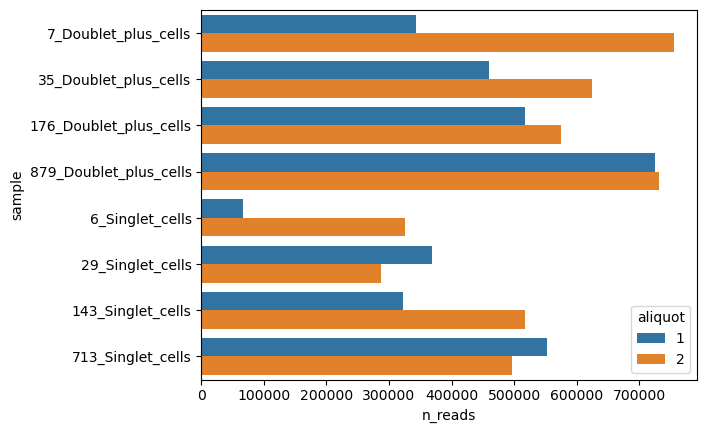

In [146]:
ax = sns.barplot(
    data=df_data.assign(sample=df_data['sample'].str.replace('_aliquot_[12]', '', regex=True)).loc[df_data['read'] == 1],
    x='n_reads',
    y='sample',
    hue='aliquot')

# FastQC

In [35]:
dir_fastqc = os.path.join(DIR_PROC, 'fastqc')
os.makedirs(dir_fastqc, exist_ok=True)

In [36]:
paths_fastq_raw = []
for filename in df_data['filename']:
    path_fastqc = os.path.join(dir_fastqc, filename.replace('.fastq.gz', '_fastqc.html'))
    if not os.path.exists(path_fastqc):
        paths_fastq_raw.append(os.path.join(DIR_DATA, filename))
if len(paths_fastq_raw) > 0:
    paths_fastq_raw = ' '.join((f'"{s}"' for s in paths_fastq_raw))
    sprite_env.run(f'fastqc {paths_fastq_raw} -q -o {dir_fastqc} -t {n_threads}')

# Barcode Statistics

## Splitcode

Add barcode and UMI to read name:

`@read::[OligoRC][R1Top][R2Top][R3Top][NYStgBot][R3Bot][R2Bot][R1Bot][Oligo] RX:Z:<oligo barcode + UMI>`

In [37]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_AUX}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_AUX="$3"

PATH_CONFIG="${DIR_AUX}/splitcode_config-oligo_cell_barcode_short.tsv"

for path_R1 in "$DIR_DATA"/*R1_001.fastq.gz; do
    SAMPLE="$(echo "$path_R1" | grep -o -E -e '[0-9]+_(Singlet|Doublet_plus)_cells_aliquot_[0-9]+')"
    path_R2="$(echo "$path_R1" | sed -E -e 's/R1_001/R2_001/')"
    PATH_MAPPING="${DIR_AUX}/mapping-${SAMPLE}.tsv"
    PATH_SUMMARY="${DIR_AUX}/summary-${SAMPLE}.json"
    PATH_OUTPUT="${DIR_PROC}/read_names-${SAMPLE}.txt.gz"

    if [ ! -f "$PATH_OUTPUT" ]; then
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=2 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 4 \
            --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
            --select=0 --pipe "$path_R1" "$path_R2" |
        awk '$1 ~ /^>/' |
        gzip > "$PATH_OUTPUT"
    fi
done

## Parsing identified barcodes to counts

In [38]:
regex_oligo_cell_barcode = re.compile((
    r'\[OligoRC_(?P<R1_oligo>bc\d)\]'
    r'\[R1Top_(?P<R1_R1>\d+)\]'
    r'\[R2Top_(?P<R1_R2>\d+)\]'
    r'\[R3Top_(?P<R1_R3>\d+)\]'
    r'(?P<barcode>'
    r'\[NYStgBot_(?P<R2_Y>\d+)\]'
    r'\[R3Bot_(?P<R2_R3>\d+)\]'
    r'\[R2Bot_(?P<R2_R2>\d+)\]'
    r'\[R1Bot_(?P<R2_R1>\d+)\])'
    r'\[Oligo_(?P<R2_oligo>bc\d)\]'))
regex_umi = re.compile(r'RX:Z:([ATCG]+)')

In [40]:
all_samples = dict()
for sample in df_data['sample'].unique():
    path_cell_barcodes = os.path.join(DIR_PROC, f'read_names-{sample}.txt.gz')
    path_cell_counts = os.path.join(DIR_PROC, f'cell_barcode_counts-{sample}.json.gz')
    if not os.path.exists(path_cell_counts):
        cells = dict()
        different_R1_R2_tags = 0
        no_match = 0
        with gzip.open(path_cell_barcodes, 'rt') as f:
            for name in f:
                name = name.strip()
                match = regex_oligo_cell_barcode.search(name)
                if match:
                    tags = match.groupdict()
                    if (tags['R1_oligo'] != tags['R2_oligo']) or \
                       (tags['R1_R1'] != tags['R2_R1']) or \
                       (tags['R1_R2'] != tags['R2_R2']) or \
                       (tags['R1_R3'] != tags['R2_R3']):
                        different_R1_R2_tags += 1
                    else:
                        barcode = tags['barcode']
                        umi = regex_umi.search(name).group(1)
                        if barcode not in cells:
                            cells[barcode] = collections.defaultdict(int)
                        cells[barcode][umi] += 1
                else:
                    no_match += 1
        with gzip.open(path_cell_counts, 'wt') as f:
            json.dump(cells, f)
        print((
            f'{sample}: {different_R1_R2_tags} reads with different barcodes detected in read 1 vs. read 2, '
            f'{no_match} reads with unmatched barcode'))
    else:
        print(f'{sample}: loading existing counts')
        with gzip.open(path_cell_counts, 'rt') as f:
            cells = json.load(f)
    all_samples[sample] = cells

7_Doublet_plus_cells_aliquot_1: 4 reads with different barcodes detected in read 1 vs. read 2, 0 reads with unmatched barcode
7_Doublet_plus_cells_aliquot_2: 42 reads with different barcodes detected in read 1 vs. read 2, 0 reads with unmatched barcode
35_Doublet_plus_cells_aliquot_1: 3 reads with different barcodes detected in read 1 vs. read 2, 0 reads with unmatched barcode
35_Doublet_plus_cells_aliquot_2: 7 reads with different barcodes detected in read 1 vs. read 2, 0 reads with unmatched barcode
176_Doublet_plus_cells_aliquot_1: 2 reads with different barcodes detected in read 1 vs. read 2, 0 reads with unmatched barcode
176_Doublet_plus_cells_aliquot_2: 4 reads with different barcodes detected in read 1 vs. read 2, 0 reads with unmatched barcode
879_Doublet_plus_cells_aliquot_1: 6 reads with different barcodes detected in read 1 vs. read 2, 0 reads with unmatched barcode
879_Doublet_plus_cells_aliquot_2: 13 reads with different barcodes detected in read 1 vs. read 2, 0 reads wit

all_samples
- key: sample_name
- value: sample
  - key: cell barcode
  - value: cell
    - key: UMI
    - value: count

In [41]:
print('Total number of read pairs with correct barcode structure:',
      sum(sum(cell.values()) for sample in all_samples.values() for cell in sample.values()))

Total number of read pairs with correct barcode structure: 6924071


## Analyzing barcode count distributions

In [137]:
dist_oligos = {}
dist_unique_oligos = {}
for sample_name, sample in all_samples.items():
    dist_oligos[sample_name] = pd.Series(sum(cell.values()) for cell in sample.values())
    dist_unique_oligos[sample_name] = pd.Series(map(len, sample.values()))

In [161]:
for sample_name, sample in all_samples.items():
    print(f'Number of cell barcodes in sample {sample_name}:', len(sample))
    print('Frequency of most common cell barcodes:', dist_oligos[sample_name].sort_values(ascending=False).values[:10])
    print('Frequency of most common cell barcodes (dedup):', dist_unique_oligos[sample_name].sort_values(ascending=False).values[:10])
    print()

Number of cell barcodes in sample 7_Doublet_plus_cells_aliquot_1: 25509
Frequency of most common cell barcodes: [27921  5494  4710  2640  2305  2140  2019  2013  1840  1824]
Frequency of most common cell barcodes (dedup): [22611  4691  3971  2333  1989  1812  1734  1715  1591  1587]

Number of cell barcodes in sample 7_Doublet_plus_cells_aliquot_2: 30743
Frequency of most common cell barcodes: [101904  51351  28046  11229  10535  10285   7727   7628   7583   7563]
Frequency of most common cell barcodes (dedup): [66334 37413 21999  9176  8524  8471  6340  6313  6257  6245]

Number of cell barcodes in sample 35_Doublet_plus_cells_aliquot_1: 46085
Frequency of most common cell barcodes: [10175  9881  3065  2666  2175  2079  1774  1715  1700  1656]
Frequency of most common cell barcodes (dedup): [8698 8360 2681 2360 1895 1766 1518 1494 1482 1444]

Number of cell barcodes in sample 35_Doublet_plus_cells_aliquot_2: 55522
Frequency of most common cell barcodes: [19751  8693  4292  3193  2861 

In [214]:
df_dist_oligos = pd.concat(
    [s.rename('oligos per cell').to_frame().pipe(
        lambda df: df.assign(sample=sample_name, **{'oligos per cell (norm)': df['oligos per cell'] / df['oligos per cell'].sum()})) \
     for sample_name, s in dist_oligos.items()],
    axis=0) \
    .merge(df_data.drop(columns=['filename', 'n_reads', 'read']).drop_duplicates(), how='left') \
    .astype(dict(sample='category'))
df_dist_unique_oligos = pd.concat(
    [s.rename('oligos per cell').to_frame().pipe(
        lambda df: df.assign(sample=sample_name, **{'oligos per cell (norm)': df['oligos per cell'] / df['oligos per cell'].sum()})) 
     for sample_name, s in dist_unique_oligos.items()],
    axis=0) \
    .merge(df_data.drop(columns=['filename', 'n_reads', 'read']).drop_duplicates(), how='left') \
    .astype(dict(sample='category'))

### Number of oligos per cell barcode (akin to scSPRITE Figure 1C)

In [304]:
df_dist_unique_oligos = df_dist_unique_oligos.groupby('sample', group_keys=False) \
    .apply(lambda group: group.sort_values('oligos per cell', ascending=False).assign(**{'Cell barcode ID': range(1, len(group) + 1)}))

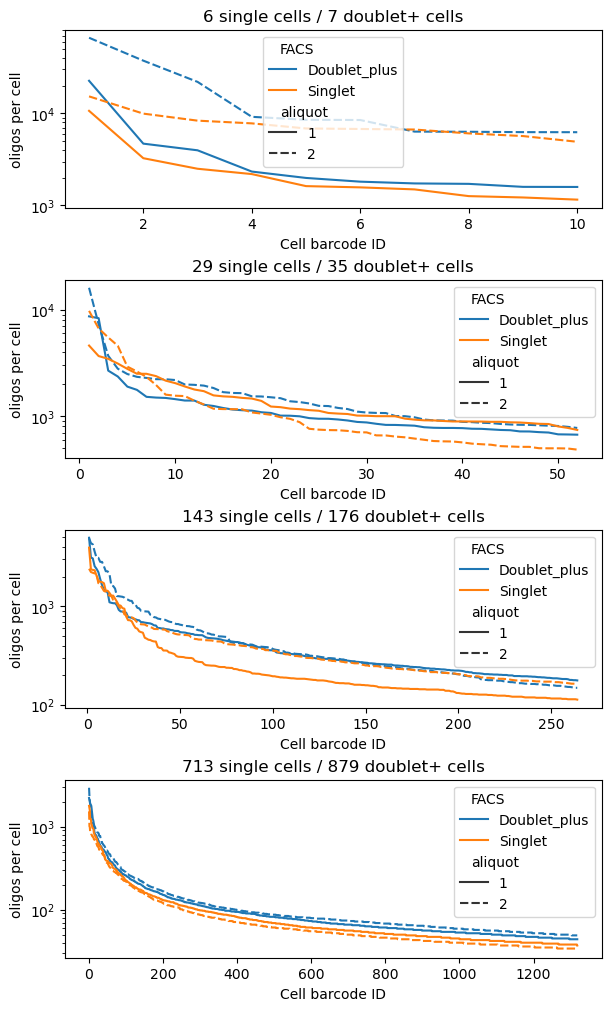

In [306]:
fig, axs = plt.subplots(4, 1, figsize=(6, 10), constrained_layout=True, sharex=False, sharey=False)
for i, cell_count_log5 in enumerate(sorted(df_dist_unique_oligos['cell_count_log5'].unique())):
    mask_cell_count_log5 = df_dist_unique_oligos['cell_count_log5'] == cell_count_log5
    cell_count_doublet = df_dist_unique_oligos.loc[
        mask_cell_count_log5 & 
        (df_dist_unique_oligos['FACS'] == 'Doublet_plus'),
        'cell_count'].unique()[0]
    cell_count_singlet = df_dist_unique_oligos.loc[
        mask_cell_count_log5 & 
        (df_dist_unique_oligos['FACS'] == 'Singlet'),
        'cell_count'].unique()[0]
    sns.lineplot(
        df_dist_unique_oligos.loc[
            mask_cell_count_log5 &
            (df_dist_unique_oligos['Cell barcode ID'] <= 1.5 * cell_count_doublet)],
        x='Cell barcode ID',
        y='oligos per cell',
        hue='FACS',
        style='aliquot',
        ax=axs[i])
    axs[i].set(title=f'{cell_count_singlet} single cells / {cell_count_doublet} doublet+ cells')
    axs[i].set_yscale('log')

# # alternatively, plot everything in one go, but the axis limits would need to be adjusted
# sns.relplot(
#     df_dist_unique_oligos.loc[df_dist_unique_oligos['cell ID'] < 1000],
#     kind='line',
#     x='Cell barcode ID',
#     y='oligos per cell',
#     hue='FACS',
#     col='cell_count_log5',
#     errorbar='sd',
#     facet_kws=dict(sharey=False)
# )

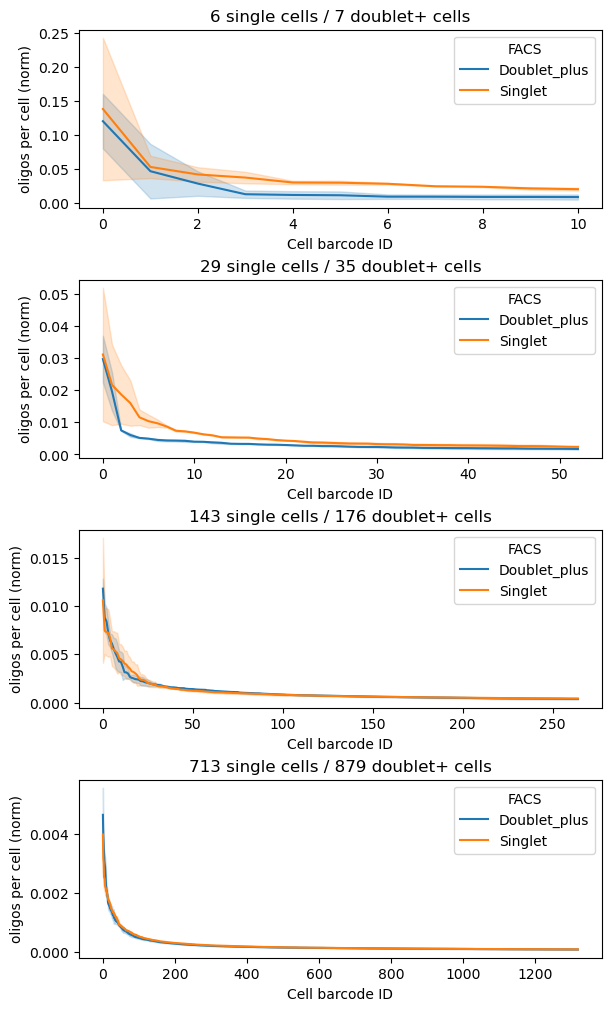

In [213]:
fig, axs = plt.subplots(4, 1, figsize=(6, 10), constrained_layout=True, sharex=False, sharey=False)
for i, cell_count_log5 in enumerate(sorted(df_dist_unique_oligos['cell_count_log5'].unique())):
    mask_cell_count_log5 = df_dist_unique_oligos['cell_count_log5'] == cell_count_log5
    cell_count_doublet = df_dist_unique_oligos.loc[
        mask_cell_count_log5 & 
        (df_dist_unique_oligos['FACS'] == 'Doublet_plus'),
        'cell_count'].unique()[0]
    cell_count_singlet = df_dist_unique_oligos.loc[
        mask_cell_count_log5 & 
        (df_dist_unique_oligos['FACS'] == 'Singlet'),
        'cell_count'].unique()[0]
    sns.lineplot(
        df_dist_unique_oligos.loc[
            mask_cell_count_log5 &
            (df_dist_unique_oligos['Cell barcode ID'] <= 1.5 * cell_count_doublet)],
        x='Cell barcode ID',
        y='oligos per cell (norm)',
        hue='FACS',
        errorbar='sd',
        ax=axs[i])
    axs[i].set(title=f'{cell_count_singlet} single cells / {cell_count_doublet} doublet+ cells')

# # alternatively, plot everything in one go, but the axis limits would need to be adjusted
# sns.relplot(
#     df_dist_unique_oligos.loc[df_dist_unique_oligos['cell ID'] < 1000],
#     kind='line',
#     x='Cell barcode ID',
#     y='oligos per cell',
#     hue='FACS',
#     col='cell_count_log5',
#     errorbar='sd',
#     facet_kws=dict(sharey=False)
# )

### Distribution of oligos per cell

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


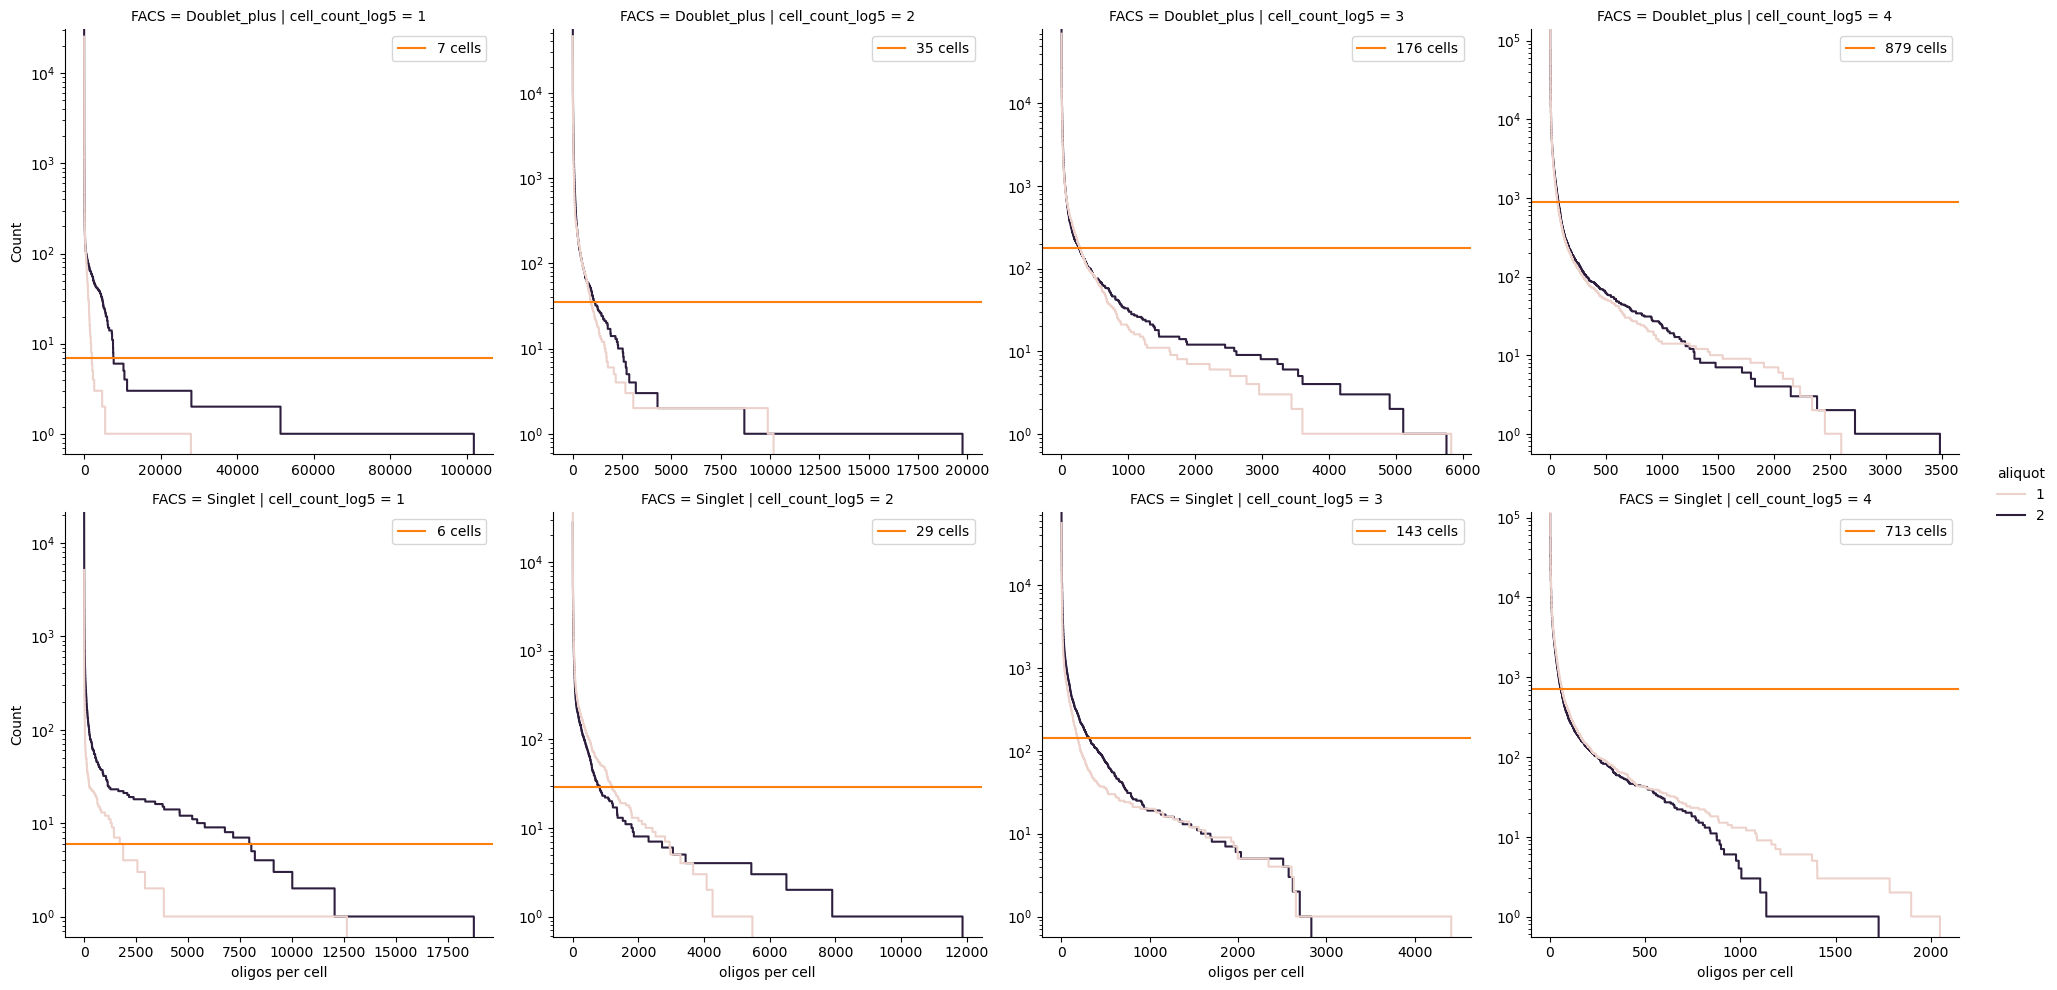

In [148]:
g = sns.displot(
    df_dist_oligos,
    kind='ecdf',
    x='oligos per cell',
    hue='aliquot',
    row='FACS',
    col='cell_count_log5',
    log_scale=(False, True),
    facet_kws=dict(sharex=False, sharey=False),
    stat='count',
    complementary=True)
for (row_val, col_val), ax in g.axes_dict.items():
    cell_counts = df_data.loc[(df_data['FACS'] == row_val) & (df_data['cell_count_log5'] == col_val), 'cell_count'].unique()
    assert len(cell_counts) == 1
    ax.axhline(y=cell_counts[0], c='C1', label=f'{cell_counts[0]} cells')
    ax.legend()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


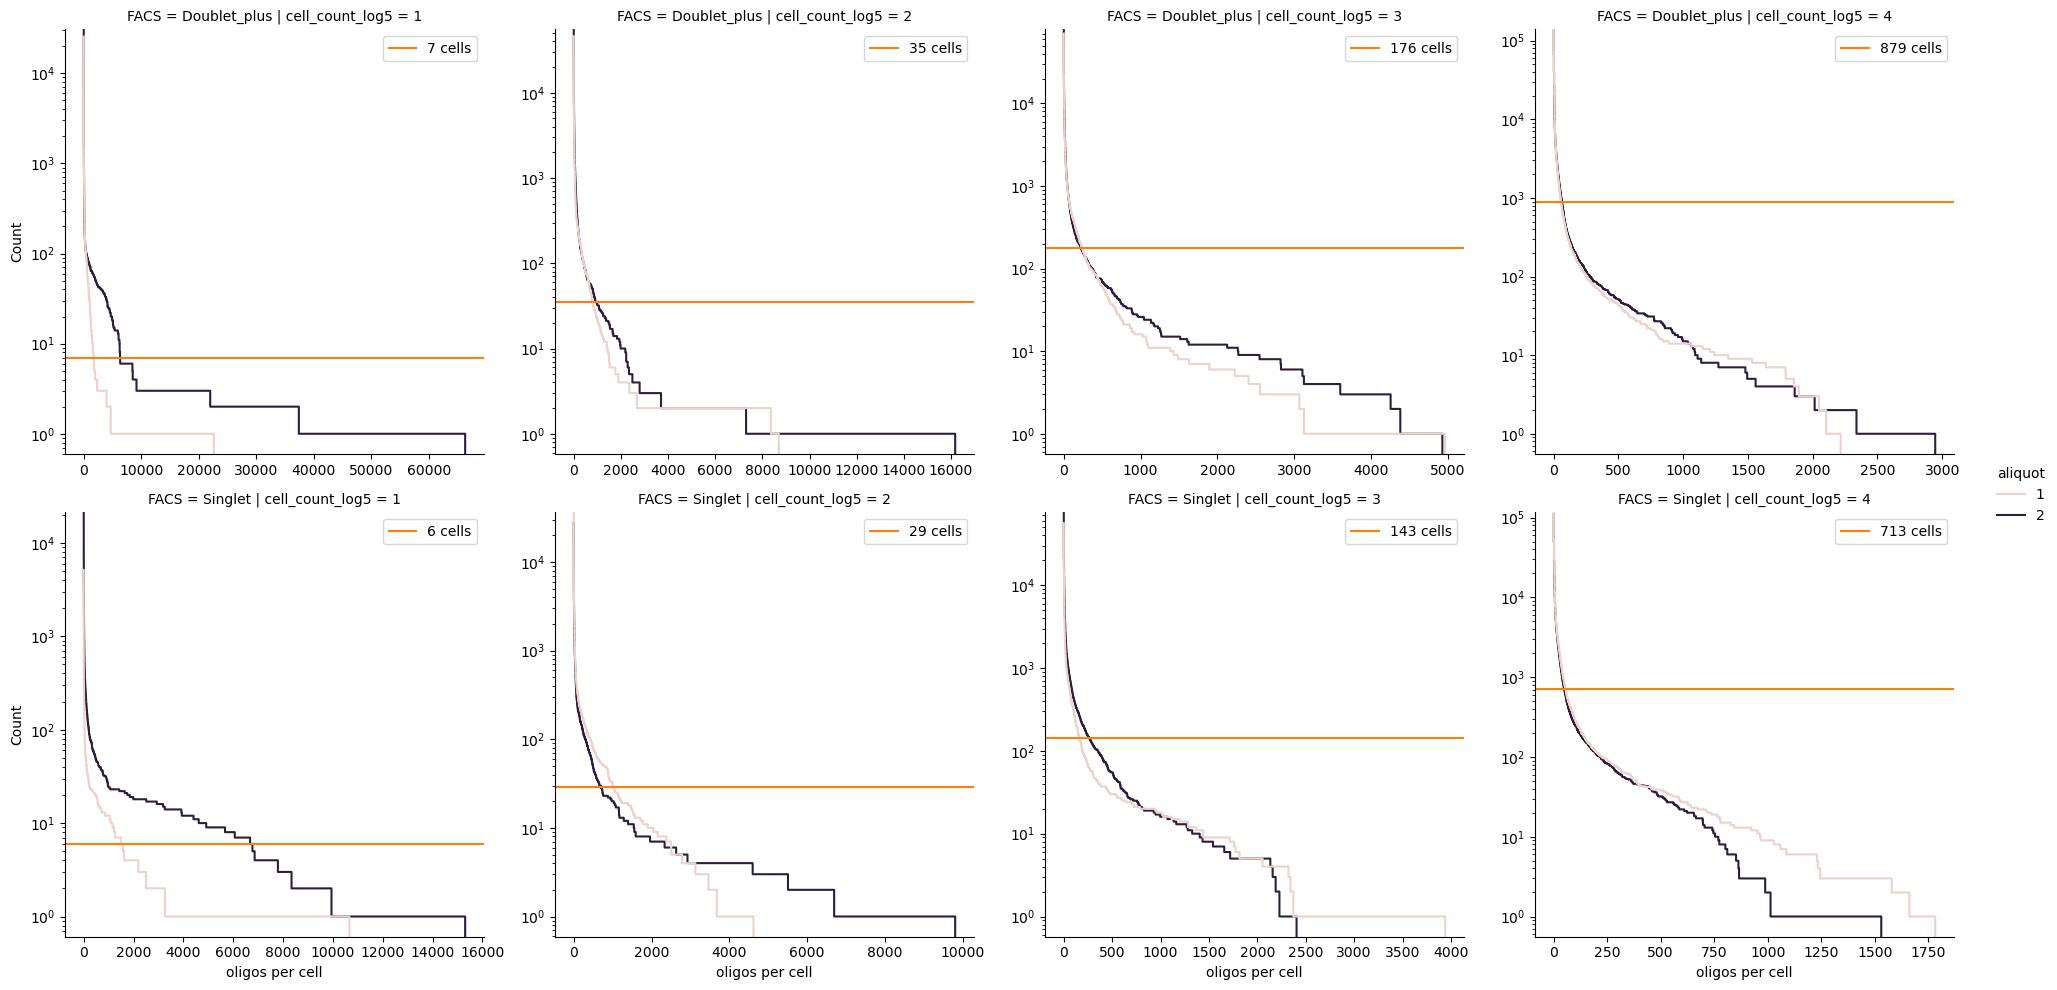

In [149]:
g = sns.displot(
    df_dist_unique_oligos,
    kind='ecdf',
    x='oligos per cell',
    hue='aliquot',
    row='FACS',
    col='cell_count_log5',
    log_scale=(False, True),
    facet_kws=dict(sharex=False, sharey=False),
    stat='count',
    complementary=True)
for (row_val, col_val), ax in g.axes_dict.items():
    cell_counts = df_data.loc[(df_data['FACS'] == row_val) & (df_data['cell_count_log5'] == col_val), 'cell_count'].unique()
    assert len(cell_counts) == 1
    ax.axhline(y=cell_counts[0], c='C1', label=f'{cell_counts[0]} cells')
    ax.legend()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


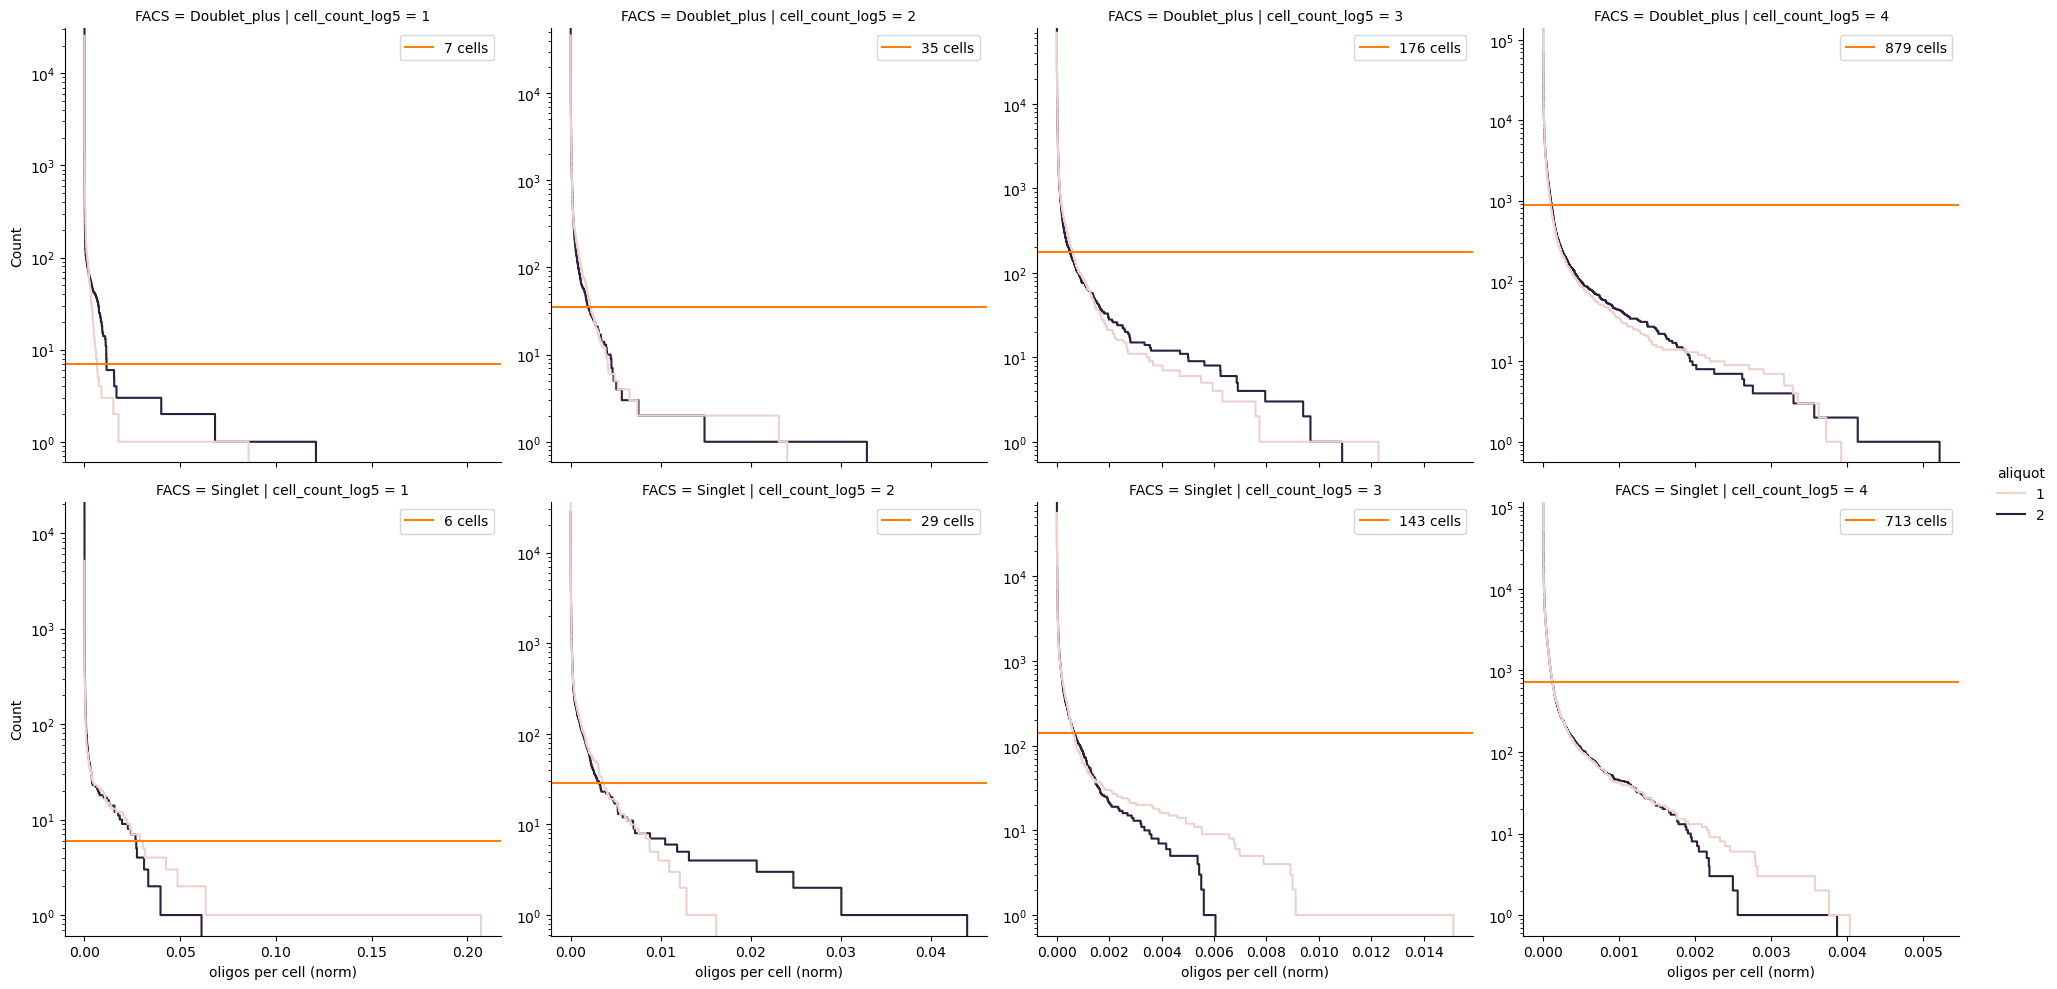

In [157]:
g = sns.displot(
    df_dist_unique_oligos,
    kind='ecdf',
    x='oligos per cell (norm)',
    hue='aliquot',
    row='FACS',
    col='cell_count_log5',
    log_scale=(False, True),
    facet_kws=dict(sharex='col', sharey=False),
    stat='count',
    complementary=True)
for (row_val, col_val), ax in g.axes_dict.items():
    cell_counts = df_data.loc[(df_data['FACS'] == row_val) & (df_data['cell_count_log5'] == col_val), 'cell_count'].unique()
    assert len(cell_counts) == 1
    ax.axhline(y=cell_counts[0], c='C1', label=f'{cell_counts[0]} cells')
    ax.legend()

Interpretation
- Doublet+ vs. singlet comparison: doublets and singlets have similar numbers of cells, but different number of "clusters." Each singlet cell corresponds to 1 cluster, while multiple doublet cells presumably split-pooled together as a single cluster. Therefore, for a given cell count, I expect there to be more identifiable clusters in the singlet aliquots compared to the doublet aliquots. This should show up in the reverse ECDFs as the horizontal line intersecting the ECDF curves further (higher) into the "noise" in the doublet aliquots.
  - This motivates the plots below, where we look at the proportion of oligos belonging to the expected number of clusters. If we look at (roughly) the same number of cell barcodes ("clusters") in a doublet+ samples as in a singlet sample, we expect a greater proportion of oligos to belong to those cell barcodes than in singlet samples, because some of those cell barcodes presumably represent multiple cells and therefore are expected to account for a larger number of oligos. However, this trend is not verified in the plots below.

In [152]:
proportion_cell_unique_oligos = {}
for sample_name, s in dist_unique_oligos.items():
    cell_count = int(sample_name.split('_')[0])
    proportion_cell_unique_oligos[sample_name] = s.sort_values(ascending=False)[:cell_count].sum() / s.sum()
df_proportion_cell_unique_oligos = pd.Series(proportion_cell_unique_oligos).rename_axis('sample').rename('proportion').to_frame().reset_index() \
    .merge(df_data.drop(columns=['filename', 'n_reads', 'read']).drop_duplicates(), how='left')

proportion_cell_oligos = {}
for sample_name, s in dist_oligos.items():
    cell_count = int(sample_name.split('_')[0])
    proportion_cell_oligos[sample_name] = s.sort_values(ascending=False)[:cell_count].sum() / s.sum()
df_proportion_cell_oligos = pd.Series(proportion_cell_oligos).rename_axis('sample').rename('proportion').to_frame().reset_index() \
    .merge(df_data.drop(columns=['filename', 'n_reads', 'read']).drop_duplicates(), how='left')

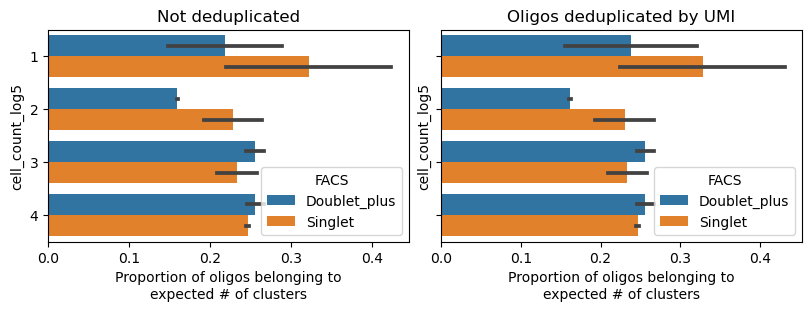

In [159]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, sharey=True)

sns.barplot(
    df_proportion_cell_unique_oligos.assign(
        sample=df_proportion_cell_unique_oligos['sample'].str.replace('_aliquot_[12]', '', regex=True)) \
        .astype(dict(cell_count_log5='str')),
    x='proportion',
    y='cell_count_log5',
    hue='FACS',
    ax=axs[0])
axs[0].set(title='Not deduplicated',
           xlabel='Proportion of oligos belonging to\nexpected # of clusters')

sns.barplot(
    df_proportion_cell_oligos.assign(
        sample=df_proportion_cell_oligos['sample'].str.replace('_aliquot_[12]', '', regex=True)) \
        .astype(dict(cell_count_log5='str')),
    x='proportion',
    y='cell_count_log5',
    hue='FACS',
    ax=axs[1])
axs[1].set(title='Oligos deduplicated by UMI',
           xlabel='Proportion of oligos belonging to\nexpected # of clusters')

fig.show()

For the most common cell barcode from each sample, plot the distribution of UMI counts

In [ ]:
dist_oligos[sample_name] = pd.Series(sum(cell.values()) for cell in sample.values())
    dist_unique_oligos[sample_name] = pd.Series(map(len, sample.values()))

In [178]:
df_umi_dists = []
for sample_name, sample in all_samples.items():
    for cell, umis in sample.items():
        if sum(umis.values()) == dist_oligos[sample_name].max():
            df_umi_dists.append(pd.DataFrame(dict(sample=sample_name, barcode=cell, umi_counts=umis.values())))
            break
df_umi_dists = pd.concat(df_umi_dists, axis=0).astype(dict(sample='category', barcode='category'))

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


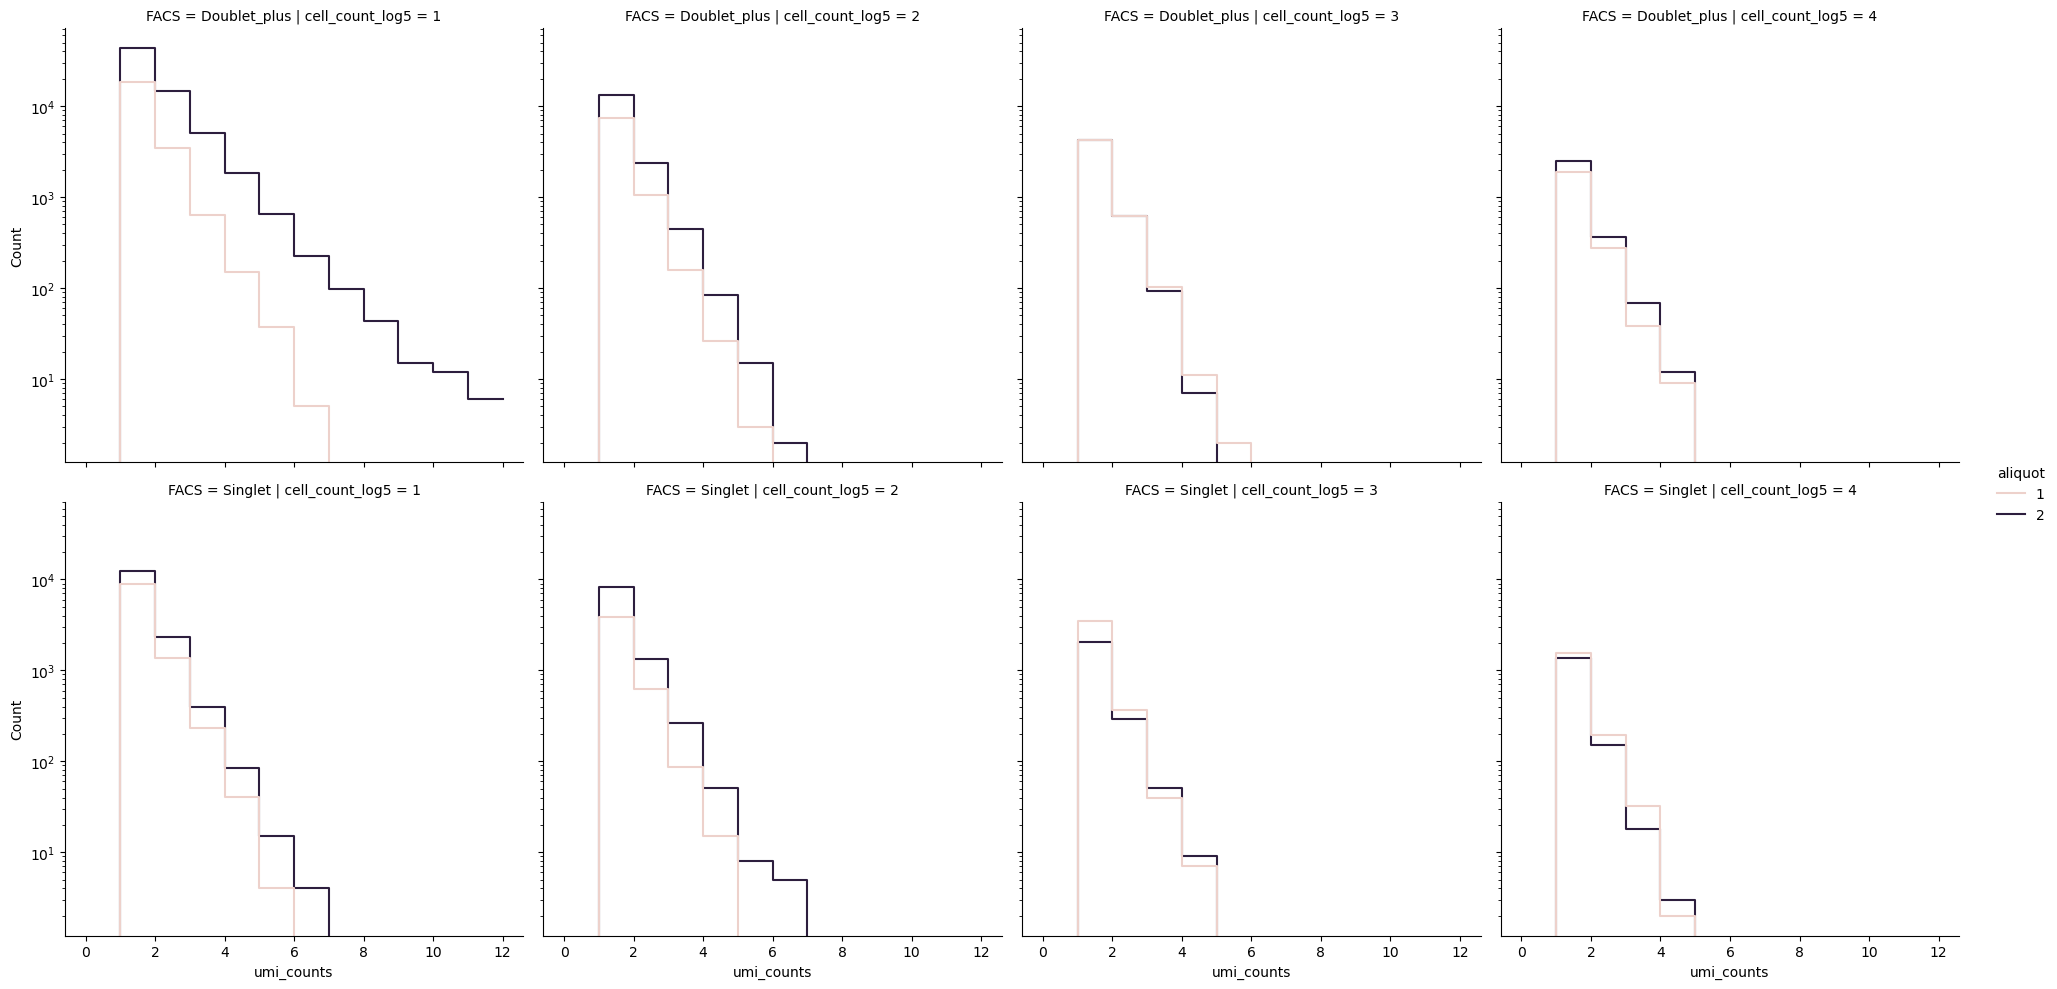

In [191]:
sns.displot(
    df_umi_dists.merge(df_data.drop(columns=['filename', 'n_reads', 'read']).drop_duplicates(), how='left'),
    kind='hist',
    x='umi_counts',
    hue='aliquot',
    row='FACS',
    col='cell_count_log5',
    bins=list(range(13)),
    element='step',
    fill=False,
    log_scale=(False, True))

### Recluster allowing for 1 tag substitution

In [242]:
df_umi_counts = {}
for sample_name, cells in all_samples.items():
    df_umi_counts[sample_name] = []
    for barcode, cell in cells.items():
        for umi, count in cell.items():
            df_umi_counts[sample_name].append([sample_name, barcode, umi, count])
    df_umi_counts[sample_name] = pd.DataFrame(df_umi_counts[sample_name], columns=['sample', 'barcode', 'umi', 'count']) \
        .astype(dict(sample='category', barcode='category'))

In [256]:
df_oligo_counts_unique = {}
df_oligo_counts = {}
for sample_name in df_umi_counts:
    df_oligo_counts_unique[sample_name] = df_umi_counts[sample_name] \
        .groupby('barcode')['umi'].count().rename('count') \
        .sort_values(ascending=False)
    df_oligo_counts[sample_name] = df_umi_counts[sample_name] \
        .groupby('barcode')['count'].sum() \
        .sort_values(ascending=False)

In [258]:
df_oligo_counts_clustered = {}
for sample_name in df_oligo_counts:
    tmp = df_oligo_counts[sample_name].sort_values(ascending=False).to_frame()
    tmp['Y'] = tmp.index.str.extract('\[NYStgBot_(\d+)\]', expand=False).astype(int)
    tmp['R1'] = tmp.index.str.extract('\[R1Bot_(\d+)\]', expand=False).astype(int)
    tmp['R2'] = tmp.index.str.extract('\[R2Bot_(\d+)\]', expand=False).astype(int)
    tmp['R3'] = tmp.index.str.extract('\[R3Bot_(\d+)\]', expand=False).astype(int)
    df_oligo_counts_clustered[sample_name] = []
    while len(tmp) > 0:
        current_barcode = tmp.iloc[0].copy()
        mask_R1 = tmp['R1'] == current_barcode['R1']
        mask_R2 = tmp['R2'] == current_barcode['R2']
        mask_R3 = tmp['R3'] == current_barcode['R3']
        mask_Y = tmp['Y'] == current_barcode['Y']
        mask_cluster = \
            (mask_R1 & mask_R2 & mask_R3) | \
            (mask_R1 & mask_R2 & mask_Y) | \
            (mask_R1 & mask_Y & mask_R3) | \
            (mask_Y & mask_R2 & mask_R3)
        current_barcode['count'] = tmp.loc[mask_cluster, 'count'].sum()
        df_oligo_counts_clustered[sample_name].append(current_barcode)
        tmp = tmp.loc[~mask_cluster]
    df_oligo_counts_clustered[sample_name] = pd.concat(df_oligo_counts_clustered[sample_name], axis=1).T

In [264]:
df_oligo_counts_unique_clustered = {}
for sample_name in df_oligo_counts_unique:
    tmp = df_oligo_counts_unique[sample_name].sort_values(ascending=False).to_frame()
    tmp['Y'] = tmp.index.str.extract('\[NYStgBot_(\d+)\]', expand=False).astype(int)
    tmp['R1'] = tmp.index.str.extract('\[R1Bot_(\d+)\]', expand=False).astype(int)
    tmp['R2'] = tmp.index.str.extract('\[R2Bot_(\d+)\]', expand=False).astype(int)
    tmp['R3'] = tmp.index.str.extract('\[R3Bot_(\d+)\]', expand=False).astype(int)
    df_oligo_counts_unique_clustered[sample_name] = []
    while len(tmp) > 0:
        current_barcode = tmp.iloc[0].copy()
        mask_R1 = tmp['R1'] == current_barcode['R1']
        mask_R2 = tmp['R2'] == current_barcode['R2']
        mask_R3 = tmp['R3'] == current_barcode['R3']
        mask_Y = tmp['Y'] == current_barcode['Y']
        mask_cluster = \
            (mask_R1 & mask_R2 & mask_R3) | \
            (mask_R1 & mask_R2 & mask_Y) | \
            (mask_R1 & mask_Y & mask_R3) | \
            (mask_Y & mask_R2 & mask_R3)
        current_barcode['count'] = tmp.loc[mask_cluster, 'count'].sum()
        df_oligo_counts_unique_clustered[sample_name].append(current_barcode)
        tmp = tmp.loc[~mask_cluster]
    df_oligo_counts_unique_clustered[sample_name] = pd.concat(df_oligo_counts_unique_clustered[sample_name], axis=1).T

In [266]:
for sample_name in df_oligo_counts_clustered:
    df_oligo_counts_clustered[sample_name] = df_oligo_counts_clustered[sample_name] \
        .drop(columns=['R1', 'R2', 'R3', 'Y']) \
        .assign(sample=sample_name)
df_oligo_counts_clustered = pd.concat(df_oligo_counts_clustered.values(), axis=0)

In [279]:
for sample_name in df_oligo_counts_unique_clustered:
    df_oligo_counts_unique_clustered[sample_name] = df_oligo_counts_unique_clustered[sample_name] \
        .drop(columns=['R1', 'R2', 'R3', 'Y']) \
        .assign(sample=sample_name)
df_oligo_counts_unique_clustered = pd.concat(df_oligo_counts_unique_clustered.values(), axis=0)

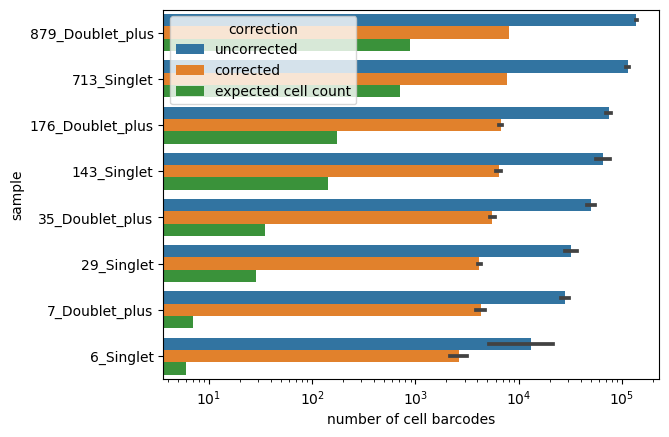

In [339]:
ax = sns.barplot(
    pd.concat(
        (df_dist_unique_oligos['sample'].value_counts().rename('uncorrected'),
         df_oligo_counts_unique_clustered['sample'].value_counts().rename('corrected')),
        axis=1).reset_index() \
        .merge(df_data[['sample', 'FACS', 'cell_count']].drop_duplicates().rename(columns=dict(cell_count='expected cell count'))) \
        .pipe(lambda df: df.assign(sample=df['sample'].str.replace('_cells_aliquot_[12]$', '', regex=True))) \
        .melt(id_vars=['sample', 'FACS'], var_name='correction', value_name='number of cell barcodes'),
    y='sample',
    x='number of cell barcodes',
    hue='correction')
ax.set_xscale('log')

#### Number of oligos per cell barcode (akin to scSPRITE Figure 1C)

In [297]:
df_dist_unique_oligos_clustered = df_oligo_counts_clustered.reset_index(drop=True) \
    .groupby('sample', group_keys=False).apply(
        lambda group: group.sort_values('count', ascending=False).assign(**{
            'Cell barcode ID': list(range(1, len(group)+1)),
            'proportion unique oligos per cell': group['count'] / group['count'].sum()})) \
    .reset_index(drop=True) \
    .merge(df_data[['sample', 'FACS', 'cell_count', 'aliquot', 'cell_count_log5']].drop_duplicates()) \
    .rename(columns=dict(count='unique oligos per cell'))

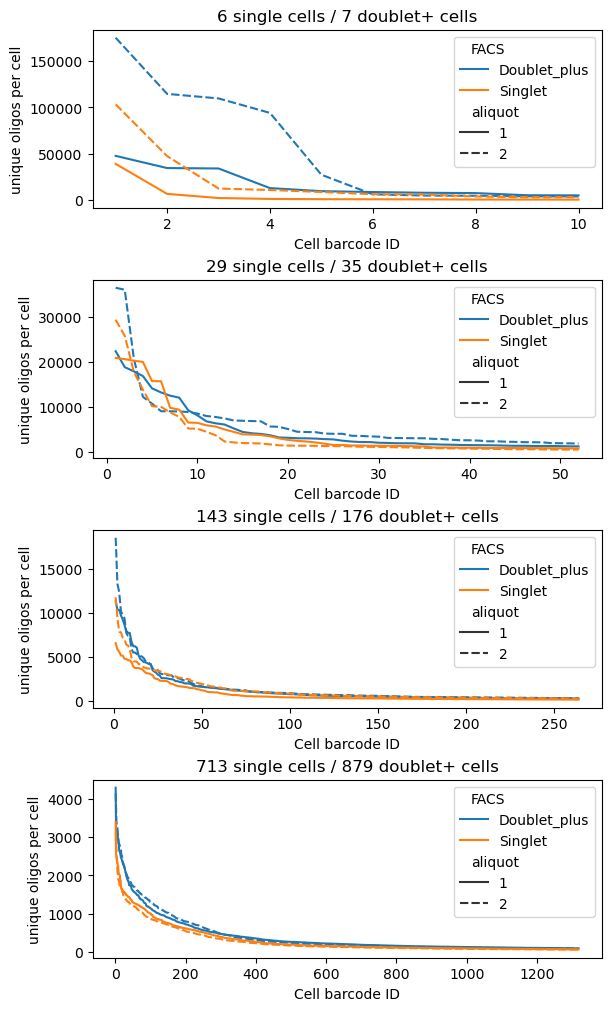

In [340]:
fig, axs = plt.subplots(4, 1, figsize=(6, 10), constrained_layout=True, sharex=False, sharey=False)
for i, cell_count_log5 in enumerate(sorted(df_dist_unique_oligos_clustered['cell_count_log5'].unique())):
    mask_cell_count_log5 = df_dist_unique_oligos_clustered['cell_count_log5'] == cell_count_log5
    cell_count_doublet = df_dist_unique_oligos_clustered.loc[
        mask_cell_count_log5 & 
        (df_dist_unique_oligos_clustered['FACS'] == 'Doublet_plus'),
        'cell_count'].unique()[0]
    cell_count_singlet = df_dist_unique_oligos_clustered.loc[
        mask_cell_count_log5 & 
        (df_dist_unique_oligos_clustered['FACS'] == 'Singlet'),
        'cell_count'].unique()[0]
    sns.lineplot(
        df_dist_unique_oligos_clustered.loc[
            mask_cell_count_log5 &
            (df_dist_unique_oligos_clustered['Cell barcode ID'] <= 1.5 * cell_count_doublet)],
        x='Cell barcode ID',
        y='unique oligos per cell',
        hue='FACS',
        style='aliquot',
        ax=axs[i])
    axs[i].set_title(f'{cell_count_singlet} single cells / {cell_count_doublet} doublet+ cells')
    # axs[i].set_yscale('log')

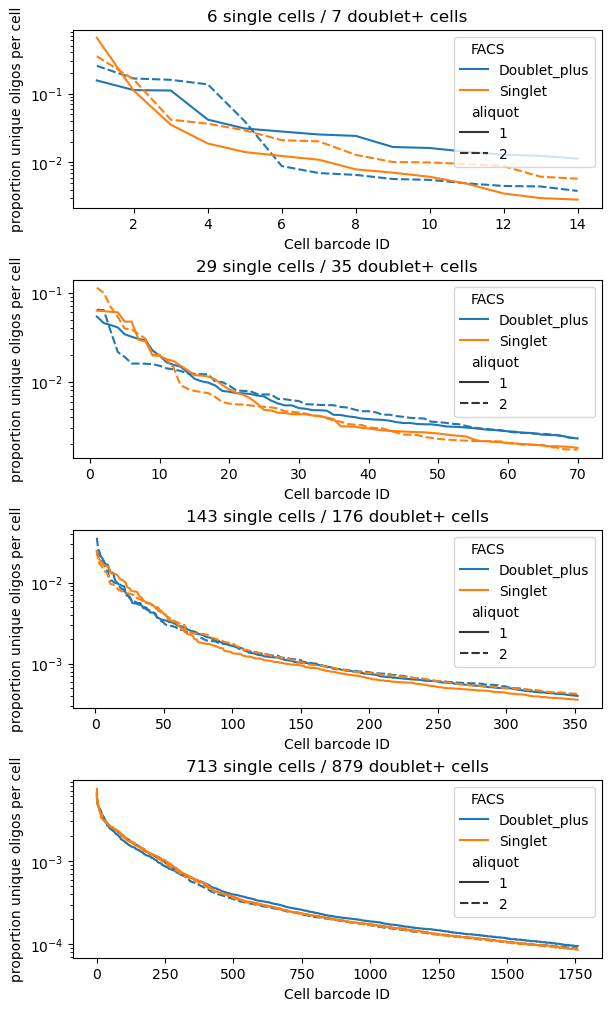

In [300]:
fig, axs = plt.subplots(4, 1, figsize=(6, 10), constrained_layout=True, sharex=False, sharey=False)
for i, cell_count_log5 in enumerate(sorted(df_dist_unique_oligos_clustered['cell_count_log5'].unique())):
    mask_cell_count_log5 = df_dist_unique_oligos_clustered['cell_count_log5'] == cell_count_log5
    cell_count_doublet = df_dist_unique_oligos_clustered.loc[
        mask_cell_count_log5 & 
        (df_dist_unique_oligos_clustered['FACS'] == 'Doublet_plus'),
        'cell_count'].unique()[0]
    cell_count_singlet = df_dist_unique_oligos_clustered.loc[
        mask_cell_count_log5 & 
        (df_dist_unique_oligos_clustered['FACS'] == 'Singlet'),
        'cell_count'].unique()[0]
    sns.lineplot(
        df_dist_unique_oligos_clustered.loc[
            mask_cell_count_log5 &
            (df_dist_unique_oligos_clustered['Cell barcode ID'] <= 2 * cell_count_doublet)],
        x='Cell barcode ID',
        y='proportion unique oligos per cell',
        hue='FACS',
        style='aliquot',
        ax=axs[i])
    axs[i].set_title(f'{cell_count_singlet} single cells / {cell_count_doublet} doublet+ cells')
    axs[i].set_yscale('log')